# ATMS 523
## Module 3 Assignment
## Alison Chatham

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
import datetime as dt

In [39]:
def _read_ghcn_by_years(station_id: str, start_year: int, end_year: int) -> pd.DataFrame:
    """
    Read GHCN daily CSVs from S3 (noaa-ghcn-pds/csv/by_year/YYYY.csv),
    filter to one station, keep TMAX/TMIN, and return a tidy DataFrame.
    """
    frames = []
    usecols = ["ID", "DATE", "ELEMENT", "DATA_VALUE"]  # keep it light
    for year in range(start_year, end_year + 1):
        s3_path = f"s3://noaa-ghcn-pds/csv/by_year/{year}.csv"
        try:
            df_y = pd.read_csv(
                s3_path,
                storage_options={"anon": True},
                usecols=usecols,
                dtype={"ID": "string", "DATE": "string", "ELEMENT": "string", "DATA_VALUE": "Int64"},
                low_memory=False,
            )
        except Exception:
            # year file might not exist or be temporarily unavailable
            continue

        # Filter to station and elements of interest
        df_y = df_y[df_y["ID"] == station_id]
        if df_y.empty:
            continue

        df_y = df_y[df_y["ELEMENT"].isin(["TMAX", "TMIN"])].copy()
        df_y["DATE"] = pd.to_datetime(df_y["DATE"], errors="coerce")
        df_y = df_y.dropna(subset=["DATE"])
        df_y["TEMP_C"] = df_y["DATA_VALUE"] / 10.0  # tenths °C -> °C
        df_y["DOY"] = df_y["DATE"].dt.dayofyear
        df_y["YEAR"] = df_y["DATE"].dt.year
        frames.append(df_y[["DATE", "YEAR", "DOY", "ELEMENT", "TEMP_C"]])

    if not frames:
        return pd.DataFrame(columns=["DATE", "YEAR", "DOY", "ELEMENT", "TEMP_C"])

    df = pd.concat(frames, ignore_index=True)
    return df

In [40]:
def ghcn_summary(station_id: str,
                 normals_start: int = 1991,
                 normals_end:   int = 2020,
                 records_start: int = 1900,
                 records_end:   int = 2024,
                 drop_feb29:    bool = False) -> pd.DataFrame:
    """
    Compute per-DOY:
      - record_min_temp (all-time daily record low, within records_start..records_end)
      - average_min_temp (mean TMIN over normals window)
      - average_max_temp (mean TMAX over normals window)
      - record_max_temp (all-time daily record high, within records_start..records_end)

    Returns a DataFrame with columns:
      ['doy','record_min_temp','average_min_temp','average_max_temp','record_max_temp']
    """
    # Read a wide range of years for records
    df_all = _read_ghcn_by_years(station_id, records_start, records_end)
    if df_all.empty:
        raise ValueError(f"No data found for station {station_id} in {records_start}-{records_end}.")

    if drop_feb29:
        df_all = df_all[~((df_all["DATE"].dt.month == 2) & (df_all["DATE"].dt.day == 29))]

    # Normals (1991–2020) — read only the window needed (faster than full history)
    df_norm = _read_ghcn_by_years(station_id, normals_start, normals_end)
    if df_norm.empty:
        # Fallback: use all available data for averages
        df_norm = df_all.copy()

    if drop_feb29:
        df_norm = df_norm[~((df_norm["DATE"].dt.month == 2) & (df_norm["DATE"].dt.day == 29))]

    # ---- Averages (normals) per DOY ----
    avg = (
        df_norm.groupby(["DOY", "ELEMENT"])["TEMP_C"]
        .mean()
        .unstack("ELEMENT")
        .rename(columns={"TMAX": "average_max_temp", "TMIN": "average_min_temp"})
    )

    # ---- Records per DOY (all-time in records window) ----
    rec_max = (
        df_all[df_all["ELEMENT"] == "TMAX"]
        .groupby("DOY")["TEMP_C"].max()
        .rename("record_max_temp")
    )
    rec_min = (
        df_all[df_all["ELEMENT"] == "TMIN"]
        .groupby("DOY")["TEMP_C"].min()
        .rename("record_min_temp")
    )

    out = (
        avg.join([rec_min, rec_max], how="outer")
        .reset_index()
        .rename(columns={"DOY": "doy"})
        [["doy", "record_min_temp", "average_min_temp", "average_max_temp", "record_max_temp"]]
        .sort_values("doy")
    )
    return out

In [41]:
station_id = "USW00013871"   # Huntsville Intl
# station_id = "USW00013874" # Atlanta
summary_df = ghcn_summary(station_id)

In [42]:
summary_df

,doy,record_min_temp,average_min_temp,average_max_temp,record_max_temp
0,1,-10.6,2.586667,12.943333,26.7
1,2,-10.6,3.39,12.573333,25.6
2,3,-11.7,2.526667,12.076667,23.3
3,4,-8.9,1.13,12.463333,25.0
4,5,-12.2,0.57,12.73,23.9
...,...,...,...,...,...
361,362,-9.4,2.94,13.813333,25.6
362,363,-8.3,3.0,13.853333,25.0
363,364,-11.7,1.673333,13.083333,23.9
364,365,-11.1,2.453333,13.593333,25.0


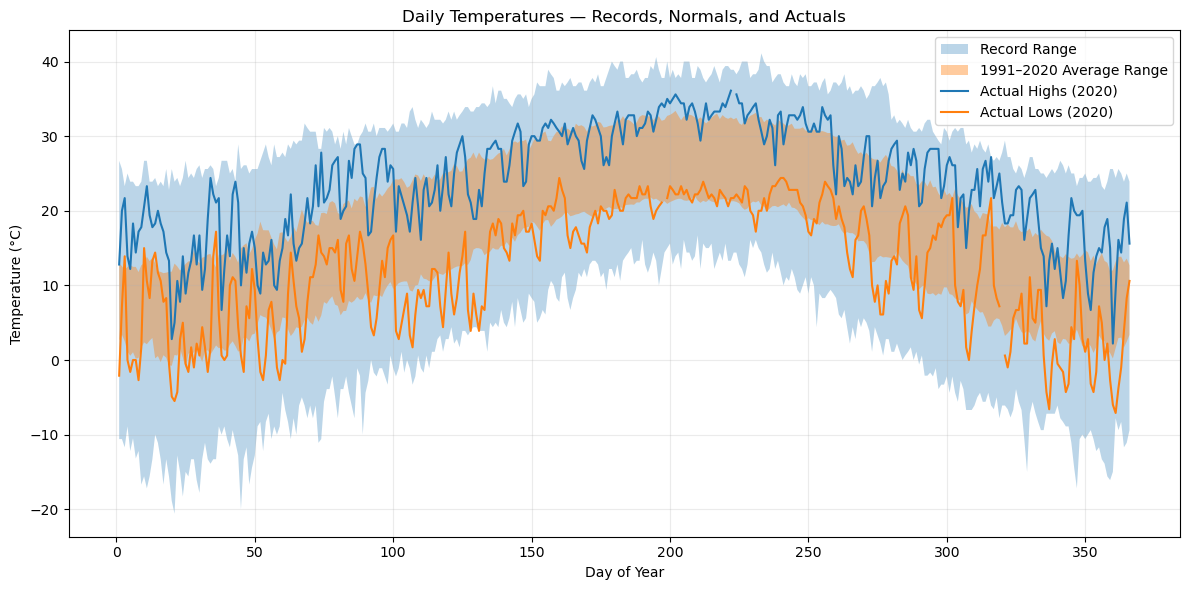

In [44]:
# Pick a year to plot actual daily highs/lows
year_to_plot = 2020
# If that year isn't present, fall back to most common available year
df_all_for_actual = _read_ghcn_by_years(station_id, year_to_plot, year_to_plot)
if df_all_for_actual.empty:
    df_all_for_actual = _read_ghcn_by_years(station_id, 1991, 2024)
    if df_all_for_actual.empty:
        raise ValueError("Could not load data for plotting actuals.")
    year_to_plot = int(df_all_for_actual["YEAR"].mode()[0])

# Build actual TMAX/TMIN for the chosen year
act = (
    df_all_for_actual[df_all_for_actual["YEAR"] == year_to_plot]
    .pivot_table(index="DOY", columns="ELEMENT", values="TEMP_C", aggfunc="max")
    [["TMIN","TMAX"]]
)

# Plot
plt.figure(figsize=(12,6))
plt.fill_between(summary_df["doy"], summary_df["record_min_temp"], summary_df["record_max_temp"],
                 label="Record Range", alpha=0.3)
plt.fill_between(summary_df["doy"], summary_df["average_min_temp"], summary_df["average_max_temp"],
                 label="1991–2020 Average Range", alpha=0.4)
plt.plot(act.index, act["TMAX"], label=f"Actual Highs ({year_to_plot})")
plt.plot(act.index, act["TMIN"], label=f"Actual Lows ({year_to_plot})")
plt.title("Daily Temperatures — Records, Normals, and Actuals")
plt.xlabel("Day of Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()